In [3]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset  
import torch.nn.functional as F                    

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import math
from glob import glob
import warnings
import pickle
import joblib

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

warnings.filterwarnings('ignore')

In [4]:
# center of gravity
def processing(x, y):
    def distance(x1,x2,y1,y2):
        result = []
        data_len = len(x1)
        for i in range(data_len):
            length = math.sqrt(abs((x2[i]-x1[i])**2 + (y2[i]-y1[i])**2))
            result.append(length)
        return result

    def center(xy):
        joint_len = 17
        return xy.iloc[:,:].sum(axis=1) / joint_len

    def norm(xy, body, centr):
        col_list = xy.columns
        for col in col_list:
            xy.loc[:,col] = (xy.loc[:,col] - centr) / body
        return xy
    
    def list_sum(*args):
        return [sum(data) for data in zip(*list(args))]
    
    
    # head length 
    length_head_1 = distance(x['nose'],x['left_eye'],y['nose_y'],y['left_eye_y'])
    length_head_2 = distance(x['nose'],x['right_eye'],y['nose_y'],y['right_eye_y'])
    length_head_3 = distance(x['nose'],x['left_ear'],y['nose_y'],y['left_ear_y'])
    length_head_4 = distance(x['nose'],x['right_ear'],y['nose_y'],y['right_ear_y'])
    length_head = np.maximum.reduce([length_head_1,length_head_2,length_head_3,length_head_4]).tolist()
    
    # torso length
    length_torso_1 = distance(x['left_shoulder'], x['left_hip'], y['left_shoulder_y'], y['left_hip_y'])
    length_torso_2 = distance(x['right_shoulder'], x['right_hip'], y['right_shoulder_y'], y['right_hip_y'])
    length_torso = np.maximum(length_torso_1, length_torso_2).tolist()
    
    # leg length
    length_leg_left_1 = distance(x['left_hip'], x['left_knee'], y['left_hip_y'], y['left_knee_y'])
    length_leg_left_2 = distance(x['left_knee'], x['left_ankle'], y['left_knee_y'], y['left_ankle_y'])
    length_leg_right_1 = distance(x['right_hip'], x['right_knee'], y['right_hip_y'], y['right_knee_y'])
    length_leg_right_2 = distance(x['right_knee'], x['right_ankle'], y['right_knee_y'], y['right_ankle_y'])
    
    legl = list_sum(length_leg_left_1, length_leg_left_2)
    legr = list_sum(length_leg_right_1, length_leg_right_2)
    length_leg = np.maximum(legl, legr).tolist()
    
    # body sum length
    length_body = list_sum(length_head, length_torso, length_leg)
    centr_x, centr_y = center(x), center(y)
    
    # normalization
    data_x = norm(x, length_body, centr_x)
    data_y = norm(y, length_body, centr_y)
    df = pd.merge(data_x, data_y, left_index=True, right_index=True, how='left')
    return df

# csv load
def concat_df(file_path, class_num):
    files = sorted(glob(file_path))
    assert len(files) != 0, 'csv file is none'
    
    df = pd.DataFrame()
    for file in files:
        csv_df = pd.read_csv(file)
        df = pd.concat([df, csv_df.loc[:,'nose':'right_ankle_y']])
        df['class'] = class_num
    
    return df.reset_index(drop=True)

# t result
def predict_test(model_name ,filename, clf, x_train, y_train):
    test = pd.read_csv(f'{model_name}/.csv')
    x = test.loc[:,'nose':'right_ankle']
    y = test.loc[:,'nose_y':'right_ankle_y']
    data = processing(x,y)
    clf.fit(x_train, y_train)
    result = vote.predict(data)
    return result

# accuracy_score
def acc_score(clf, x_train, y_train, x_val, y_val):
    clf.fit(x_train, y_train)
    result = clf.predict(x_val)
    return accuracy_score(y_val, result)

# cross_vaildation
def cross_vail(clf, x_train, y_train, cv):
    score = cross_val_score(clf, x_train, y_train, cv = cv)
    df = pd.DataFrame(cross_validate(clf, x_train, y_train, cv = cv))
    return score, df

# GridSearchCV
def grid_bestparam(clf, params, cv, x_train, y_train):
    grid = GridSearchCV(estimator=clf, param_grid=params, cv=cv)
    grid.fit(x_train,y_train)
    return grid.best_params_

def model_save(model_name):
    joblib.dump(vote, f"models/{model_name}.pkl")

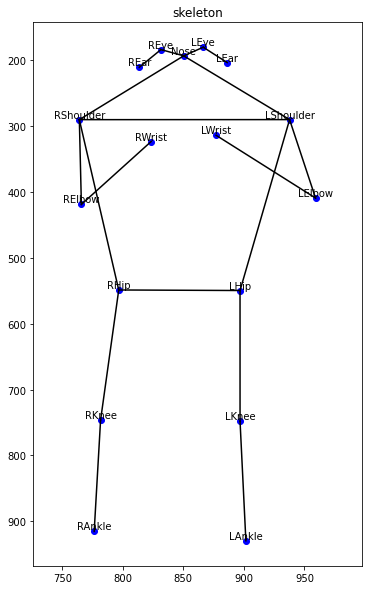

In [6]:
def plot_line(a, b):
    if (a.any()> 0 and b.any()>0): plt.plot([a[0], b[0]], [a[1], b[1]], 'k-')
        
def plot_skeleton(sample, pattern):
    
    keypoint = ['Nose', 'LEye', 'REye', 'LEar', 'REar', 'LShoulder', 'RShoulder',
                'LElbow', 'RElbow', 'LWrist', 'RWrist', 'LHip', 'RHip', 'LKnee', 'RKnee', 'LAnkle', 'RAnkle']
    
    for i in range(len(sample)//2):
        plt.plot(sample[i], sample[17+i], pattern)
        plt.text(sample[i], sample[17+i], keypoint[i], verticalalignment='bottom' , horizontalalignment='center' )
    skeleton = sample
    Nose = skeleton[[0,17]]
    LEye = skeleton[[1,18]]
    REye = skeleton[[2,19]]
    LEar = skeleton[[3,20]]
    REar = skeleton[[4,21]]
    LShoulder = skeleton[[5,22]]
    RShoulder = skeleton[[6,23]]
    LElbow = skeleton[[7,24]]
    RElbow = skeleton[[8,25]]
    LWrist = skeleton[[9,26]]
    RWrist = skeleton[[10,27]]
    LHip = skeleton[[11,28]]
    RHip = skeleton[[12,29]]
    LKnee = skeleton[[13,30]]
    RKnee = skeleton[[14,31]]
    LAnkle = skeleton[[15,32]]
    RAnkle = skeleton[[16,33]]
    
    plot_line(LEye, Nose)
    plot_line(REar, REye)
    plot_line(REye, Nose)
    plot_line(LEar, LEye)
    plot_line(LShoulder, LElbow)
    plot_line(LElbow, LWrist)
    plot_line(RShoulder, RElbow)
    plot_line(RElbow, RWrist)
    plot_line(LHip, LKnee)
    plot_line(LKnee, LAnkle)
    plot_line(RKnee, RAnkle)
    plot_line(RHip, RKnee)
    plot_line(LHip, LShoulder)
    plot_line(RHip, RShoulder)
    plot_line(RHip, LHip)
    plot_line(LShoulder, RShoulder)
    plot_line(LShoulder, Nose)
    plot_line(RShoulder, Nose)
    
def plot(sample, centr):
    
    if centr==0:
        pad_ori = 38
        plt.figure(str(sample))
        plt.subplot(131)
        plt.title('skeleton')
        X_ori = sample
        x_max = max(X_ori[:17]) + pad_ori
        x_min = min(i for i in X_ori[:17] if i > 0) - pad_ori
        y_max = max(X_ori[17:]) + pad_ori
        y_min = min(j for j in X_ori[17:] if j > 0) - pad_ori
        plt.xlim(x_min,x_max)
        plt.ylim(y_max, y_min)
        plot_skeleton(X_ori, 'bo')
    
    if centr==1:
        X_nor = sample
        pad_nor = 0.2
        #plt.figure(2)
        plt.subplot(122)
        plt.title('Normalized skeleton')
        x_max = max(X_nor[0::2]) + pad_nor
        x_min = min(X_nor[0::2]) - pad_nor
        y_max = max(X_nor[1::2]) + pad_nor
        y_min = min(X_nor[1::2]) - pad_nor
        plt.xlim(x_min,x_max)
        plt.ylim(y_max, y_min)
        plot_skeleton(X_nor, 'ro')

file_path = 'your path'
data = pd.read_csv(file_path)
plot_data = data.loc[0,'nose':'right_ankle_y'] 
plot(plot_data, 0)

In [ ]:
# SAVE FT ... True and False
SAVE_FT = True
model_nm = None

# your PATH
file_path_stop = f'{model_nm}/stop/*.csv'
file_path_change = f'{model_nm}/change/*.csv'

stop_data = concat_df(file_path_stop, 0)
chg_data = concat_df(file_path_change, 1)

concat_data = pd.concat([stop_data, chg_data])
result_data = concat_data.sample(frac=1, random_state=42).reset_index(drop=True)

x = result_data.loc[:, 'nose':'right_ankle']
y = result_data.loc[:, 'nose_y':'right_ankle_y']
df = processing(x,y)
label = result_data.loc[:, 'class']

x_train, x_val, y_train, y_val = train_test_split(df, label, test_size=0.3, random_state=42)

# randomforest, logisticregression, svc, LGBM
clf1 = RandomForestClassifier(n_estimators = 30, max_depth=3, random_state=42)
clf2 = LogisticRegression(C = 0.5, random_state=42)
clf3 = SVC(kernel = 'linear', C = 1.2, probability=True, random_state=42)
clf4 = LGBMClassifier(learning_rate = 0.1, max_depth = 3)

# ensemble
vote = VotingClassifier(estimators=[
    ('rf', clf1),('lr', clf2),('svc',clf3),('lgbm',clf4)
], voting='soft')

if SAVE_FT:
    model_save(model_nm)